In [4]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from mediapipe.python.solutions import holistic
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import numpy as np
# % matplotlib inline
np.random.seed(2017) 

#Keras, deep learning libraries
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
# from keras.utils import np_utils
from keras.utils import to_categorical
from keras import backend as K
from keras.datasets import cifar10
import os
import tensorflow as tf
from tensorflow.python.client import device_lib
from keras.callbacks import TensorBoard

import pickle
import pandas as pd
from skimage import io
from scipy import misc
import skimage.transform as st
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import h5py
from flask import Flask, request, render_template
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Set as 1 to train models, 0 to skip model training and load pre-trained models (Training takes time if using CPU)
train_models_flag = 0


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Set TensorFlow to use all available CPU cores
os.environ["OMP_NUM_THREADS"] = "auto"
os.environ["TF_NUM_INTEROP_THREADS"] = "auto"
os.environ["TF_NUM_INTRAOP_THREADS"] = "auto"

# Additional configuration options for TensorFlow session
config = tf.compat.v1.ConfigProto()
config.inter_op_parallelism_threads = os.cpu_count()
config.intra_op_parallelism_threads = os.cpu_count()
tf.compat.v1.Session(config=config)


2024-02-15 18:57:43.732758: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38374 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


In [12]:
#path for exported data, numpy arrays
# DATA_PATH = os.path.join('Frame_Data')
# IMAGES_PATH= os.path.join('/home/mahimrawal/resize frame collection')
#action that we are creating and detect
actions=np.array(['Aausadi','Ambulance','Bathroom','Be Careful','Bleeding','Call','Dhanebad','Doctor','Dont Understand','Eklopan',
                  'Emergency','Firstaid','Good Morning','Happy','Heart_attack','Hello','Help','Hospital','Name','Need','Nice To Meet You',
                  'Oxygen','Pain','Please','Police','Relax','Sign','Slowly','Sorry','What','Yes','You'])


In [4]:
data_dir = '/home/mahimrawal/Frame Collection' 


In [5]:
data = tf.keras.utils.image_dataset_from_directory(
    '/home/mahimrawal/Frame Collection',
    batch_size=128,
    image_size=(480,480),
    color_mode='grayscale'
)



Found 192000 files belonging to 32 classes.


2024-02-16 00:28:00.947124: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [6]:
len(data)


1500

In [6]:
data_iterator = data.as_numpy_iterator()


In [7]:
batch = data_iterator.next()


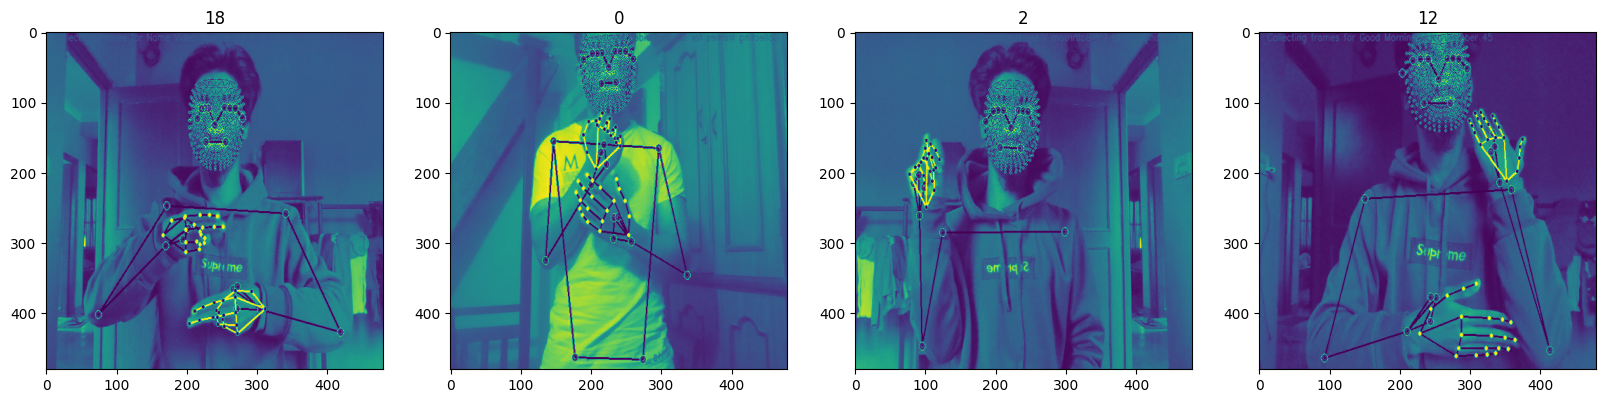

In [9]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [8]:
data = data.map(lambda x,y: (x/255, y))


In [9]:
train_size = int(len(data)*.75)
val_size = int(len(data)*.25)
# test_size = int(len(data)*.1)

In [10]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
# test = data.skip(train_size+val_size).take(test_size)

In [13]:
# Define the model

#Initialize the model
model = Sequential()

# Stacked Convolution layer
model.add(Conv2D(48, (3, 3), padding='same', input_shape=(480,480,1),activation = 'relu'))

model.add(Conv2D(48, (3, 3),activation = 'relu'))
 
# Max Pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout for regularization
model.add(Dropout(0.25))

# Stacked Convolution layer
model.add(Conv2D(96, (3, 3), padding='same',activation = 'relu'))

model.add(Conv2D(96, (3, 3),activation = 'relu'))

# Max Pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout for regularization
model.add(Dropout(0.25))

# Stacked Convolution layer
model.add(Conv2D(192, (3, 3), padding='same',activation = 'relu'))

model.add(Conv2D(192, (3, 3),activation = 'relu'))

# Max Pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully-connected layer
model.add(Dense(units = 512, activation = 'relu'))

# Dropout for regularization
model.add(Dropout(0.5))

# Fully-connected layer
model.add(Dense(units = 256, activation = 'relu'))

# Dropout for regularization
model.add(Dropout(0.5))

# Output Fully-connected layer
model.add(Dense(32, activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 480, 480, 48)      480       
                                                                 
 conv2d_1 (Conv2D)           (None, 478, 478, 48)      20784     
                                                                 
 max_pooling2d (MaxPooling2  (None, 239, 239, 48)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 239, 239, 48)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 239, 239, 96)      41568     
                                                                 
 conv2d_3 (Conv2D)           (None, 237, 237, 96)      83040     
                                                        

In [15]:
# model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])


from keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [16]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


In [17]:
# def accuracy(test_x, test_y, model):
#     result = model.predict(test_x)
#     predicted_class = np.argmax(result, axis=1)
#     true_class = np.argmax(test_y, axis=1)
#     num_correct = np.sum(predicted_class == true_class) 
#     accuracy = float(num_correct)/result.shape[0]
#     return (accuracy * 100)

In [18]:
train_models_flag=1

In [19]:
# Your code
if train_models_flag == 1:
    # Train the model
    start = time.time()
    model_info = model.fit(train, 
                           batch_size=128, epochs=13, 
                           validation_data=val, 
                           verbose=1, 
                           callbacks=[tensorboard_callback])
    end = time.time()
    model.save("handgesture-recognitioncnn.h5")
    print("Model took {} seconds to train".format(end - start))
else:
    # Load Model
    saved_model = 'saved_models/tuned_model_fin.h5'
    model = load_model(saved_model)

# Compute test accuracy
# print ("Accuracy on test data post hyperparameter tuning is: {}%".format(accuracy(test,train, model_info)))


Epoch 1/13


2024-02-15 18:57:56.374740: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-15 18:57:57.232050: W tensorflow/core/kernels/gpu_utils.cc:54] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2024-02-15 18:57:57.282490: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-15 18:57:57.970793: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-15 18:58:11.893695: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f900c02a870 initialized for platform CUDA (this does not guarantee that XLA will be used). D

1125/1125 [==============================] - 1254s 840ms/step - loss: 0.3791 - accuracy: 0.8860 - val_loss: 9.0057e-04 - val_accuracy: 0.9998
Epoch 2/13
1125/1125 [==============================] - 942s 837ms/step - loss: 0.0275 - accuracy: 0.9913 - val_loss: 1.1035e-04 - val_accuracy: 1.0000
Epoch 3/13
1125/1125 [==============================] - 937s 833ms/step - loss: 0.0150 - accuracy: 0.9954 - val_loss: 5.9954e-05 - val_accuracy: 1.0000
Epoch 4/13
1125/1125 [==============================] - 934s 830ms/step - loss: 0.0109 - accuracy: 0.9966 - val_loss: 4.9406e-05 - val_accuracy: 1.0000
Epoch 5/13
1125/1125 [==============================] - 930s 826ms/step - loss: 0.0066 - accuracy: 0.9979 - val_loss: 1.9259e-04 - val_accuracy: 1.0000
Epoch 6/13
1125/1125 [==============================] - 928s 824ms/step - loss: 0.0048 - accuracy: 0.9984 - val_loss: 3.7786e-04 - val_accuracy: 1.0000
Epoch 7/13
1125/1125 [==============================] - 924s 821ms/step - loss: 0.0042 - accuracy:

/home/mahimrawal/anaconda3/envs/chippu/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model took 12356.02359843254 seconds to train


In [20]:
# if train_models_flag == 1:
#     # Train the model

#     start = time.time()
#     model_info = model.fit(train, 
#                            batch_size=128, epochs=40, 
#                            validation_data=val, 
#                            verbose=1,callbacks=[tensorboard_callback])
#     end = time.time()
#     model.save("handgesture-recognitioncnn.h5")
    
#      # plot model history
#     # plot_model_history(model_info)
#     print ("Model took {} seconds to train".format(end - start))
# else:
#     #Load Model
#     saved_model = 'saved_models/tuned_model_fin.h5'
#     model = load_model(saved_model)
    
# #compute test accuracy
# # print ("Accuracy on test data post hyperparameter tuning is: {}%".format(accuracy(test,train, model_info)))


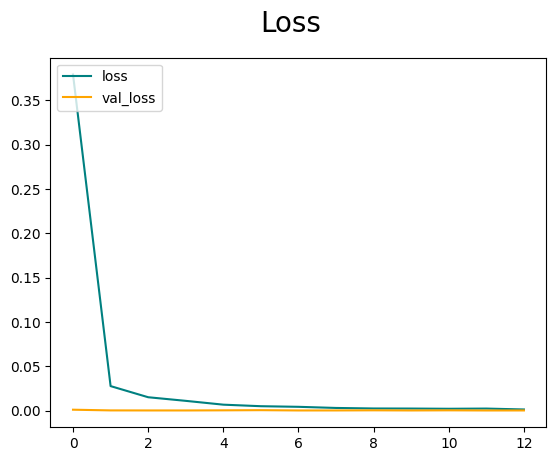

In [21]:
fig = plt.figure()
plt.plot(model_info.history['loss'], color='teal', label='loss')
plt.plot(model_info.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

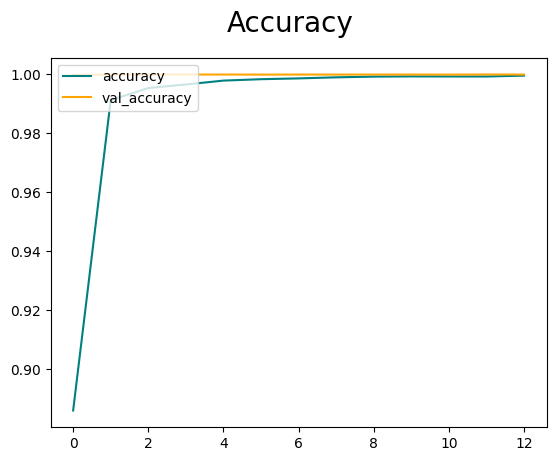

In [22]:
fig = plt.figure()
plt.plot(model_info.history['accuracy'], color='teal', label='accuracy')
plt.plot(model_info.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [1]:
from keras.models import load_model

# Provide the path to your saved model
model_path = r'/home/mahimrawal/handgesture-recognitioncnn.h5'
# model_path = r'C:\Users\Dell\Downloads\1-7.h5'

# Load the model
loaded_model = load_model(model_path)

2024-02-16 00:24:45.090320: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-16 00:24:45.141420: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 00:24:45.141455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-16 00:24:45.142846: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-16 00:24:45.151248: I tensorflow/core/platform/cpu_feature_guar

375/375 [==============================] - 137s 194ms/step


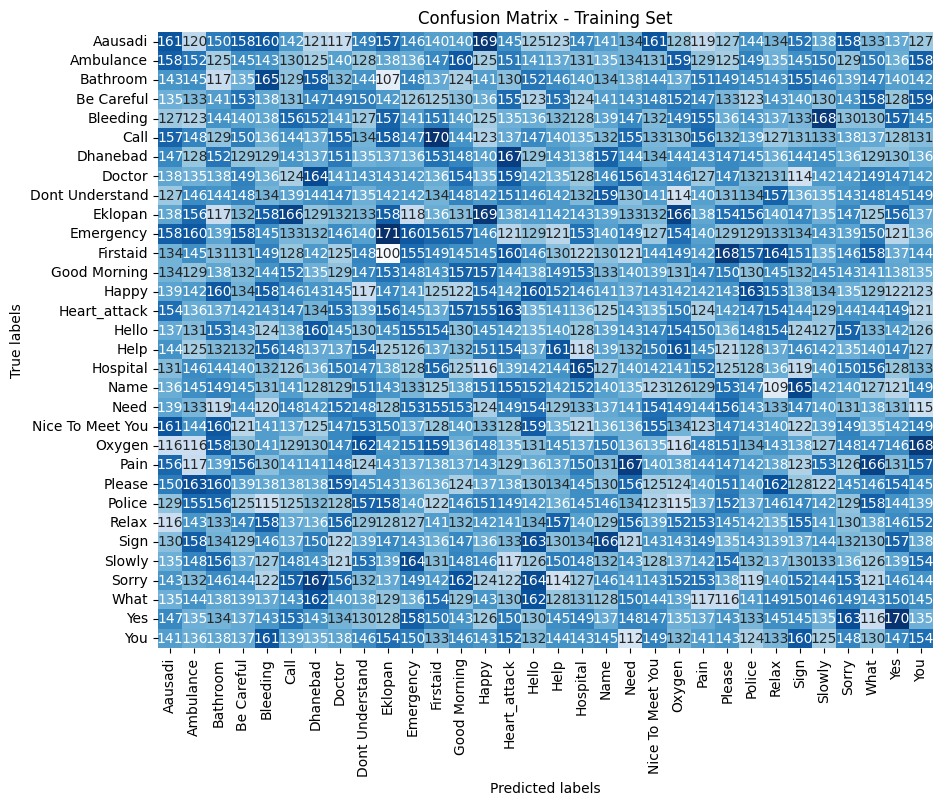

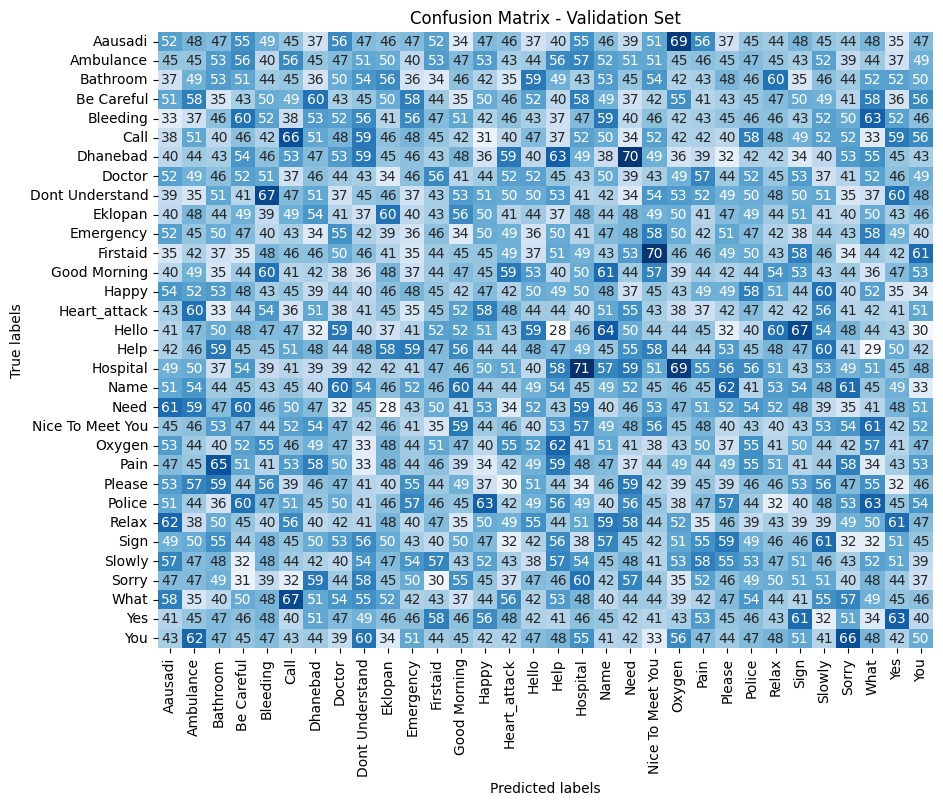

In [14]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np
# # Assuming you have already trained your model using the fit method

# # Generate predictions and true labels for training set
# y_train_pred = np.argmax(loaded_model.predict(train), axis=1)
# y_train_true = np.argmax(np.concatenate([y.numpy() for x, y in train]), axis=1)

# # Generate predictions and true labels for validation set
# y_val_pred = np.argmax(loaded_model.predict(val), axis=1)
# y_val_true = np.argmax(np.concatenate([y.numpy() for x, y in val]), axis=1)

# # Generate predictions and true labels for test set
# # y_test_pred = np.argmax(loaded_model.predict(test), axis=1)
# # y_test_true = np.argmax(np.concatenate([y.numpy() for x, y in test]), axis=1)

# # Compute confusion matrices for each set
# conf_matrix_train = confusion_matrix(y_train_true, y_train_pred)
# conf_matrix_val = confusion_matrix(y_val_true, y_val_pred)
# # conf_matrix_test = confusion_matrix(y_test_true, y_test_pred)

# # Plot the confusion matrix using seaborn heatmap for training set
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues", cbar=False, 
#             xticklabels=actions, yticklabels=actions)
# plt.xlabel('Predicted labels')
# plt.ylabel('True labels')
# plt.title('Confusion Matrix - Training Set')
# plt.show()

# # Plot the confusion matrix using seaborn heatmap for validation set
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix_val, annot=True, fmt="d", cmap="Blues", cbar=False, 
#             xticklabels=actions, yticklabels=actions)
# plt.xlabel('Predicted labels')
# plt.ylabel('True labels')
# plt.title('Confusion Matrix - Validation Set')
# plt.show()

# Plot the confusion matrix using seaborn heatmap for test set
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", cbar=False, 
#             xticklabels=actions, yticklabels=actions)
# plt.xlabel('Predicted labels')
# plt.ylabel('True labels')
# plt.title('Confusion Matrix - Test Set')
# plt.show()




from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already trained your model using the fit method

# Generate predictions and true labels for training set
y_train_pred = np.argmax(loaded_model.predict(train), axis=1)
y_train_true = np.concatenate([y for x, y in train])

# Generate predictions and true labels for validation set
y_val_pred = np.argmax(loaded_model.predict(val), axis=1)
y_val_true = np.concatenate([y for x, y in val])

# Compute confusion matrices for each set
conf_matrix_train = confusion_matrix(y_train_true, y_train_pred)
conf_matrix_val = confusion_matrix(y_val_true, y_val_pred)

# Plot the confusion matrix using seaborn heatmap for training set
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=actions, yticklabels=actions)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Training Set')
plt.show()

# Plot the confusion matrix using seaborn heatmap for validation set
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_val, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=actions, yticklabels=actions)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Validation Set')
plt.show()


In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Define a function to compute precision, recall, and F1 score
def compute_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return precision, recall, f1

# Compute metrics for training set
precision_train, recall_train, f1_train = compute_metrics(y_train_true, y_train_pred)

# Compute metrics for validation set
precision_val, recall_val, f1_val = compute_metrics(y_val_true, y_val_pred)

# Compute metrics for test set
# precision_test, recall_test, f1_test = compute_metrics(y_test_true, y_test_pred)

# Print the metrics for each set
print("Training Set:")
print("Precision: {:.4f}".format(precision_train))
print("Recall: {:.4f}".format(recall_train))
print("F1 Score: {:.4f}".format(f1_train))
print()

print("Validation Set:")
print("Precision: {:.4f}".format(precision_val))
print("Recall: {:.4f}".format(recall_val))
print("F1 Score: {:.4f}".format(f1_val))
print()

print("Test Set:")
# print("Precision: {:.4f}".format(precision_test))
# print("Recall: {:.4f}".format(recall_test))
# print("F1 Score: {:.4f}".format(f1_test))


Training Set:
Precision: 0.0326
Recall: 0.0326
F1 Score: 0.0326

Validation Set:
Precision: 0.0326
Recall: 0.0326
F1 Score: 0.0326

Test Set:


In [16]:
from sklearn.metrics import accuracy_score

# Compute accuracy score for training set
accuracy_train = accuracy_score(y_train_true, y_train_pred)

# Compute accuracy score for validation set
accuracy_val = accuracy_score(y_val_true, y_val_pred)

# Compute accuracy score for test set
# accuracy_test = accuracy_score(y_test_true, y_test_pred)

# Print the accuracy scores for each set
print("Training Set Accuracy: {:.4f}".format(accuracy_train))
print("Validation Set Accuracy: {:.4f}".format(accuracy_val))
# print("Test Set Accuracy: {:.4f}".format(accuracy_test))


Training Set Accuracy: 0.0326
Validation Set Accuracy: 0.0326


In [ ]:
# from sklearn.metrics import multilabel_confusion_matrix, accuracy_score


In [ ]:
# yhat = loaded_model.predict(X_train)


In [ ]:
# ytrue = np.argmax(y_train, axis=1).tolist()
# yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
# multilabel_confusion_matrix(ytrue,yhat)


In [ ]:
# multilabel_confusion_matrix(ytrue,yhat)


In [ ]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming you have already trained your model and obtained predictions
# # y_true are the true labels, and y_pred are the predicted labels
# # Replace y_true and y_pred with your actual data

# # Compute the confusion matrix
# conf_matrix = confusion_matrix(ytrue, yhat)

# # Plot the confusion matrix using seaborn heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
#             xticklabels=actions, yticklabels=actions)
# plt.xlabel('Predicted labels')
# plt.ylabel('True labels')
# plt.title('Confusion Matrix')
# plt.show()
